In [7]:
# from model import mix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import emcee
import corner
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
import sys

In [28]:
class mix():
    ''' Holder for the mixture model on JVS rotation models '''
    def __init__(self):
        self.rocrit_file = '../data/jvs_models/rocrit_population.h5'
        self.standard_file = '../data/jvs_models/standard_population.h5'
        self.d = '/rds/projects/2018/daviesgr-asteroseismic-computation/ojh251/malatium/models_upgrade'

        self.mapper = mapper = {'period': 'Prot',
                                'age': 'Age',
                                'mass': 'Mass'}
        self.bw = np.array([0.02, 10.0, 0.01, 0.01])
        self.mass = [0, 0]
        self.teff = [0, 0]
        self.age = [0,0]
        self.prot = [0, 0]
        self.cols = ['Mass', 'Teff', 'Age', 'Prot', 'P_A']
        self.latexcols = [r'$M$', r'$T_{\rm eff}$', r'$\log{\tau}$', r'$\log{P}$', r'$P_A$']

        self.get_data()

    def get_data(self):
        ''' load in the data and fix the column titles '''
        self.df_rocrit = pd.read_hdf(self.rocrit_file, key='sample', mode='r')
        self.df_stan = pd.read_hdf(self.standard_file, key='sample', mode='r')
        self.df_rocrit.rename(columns=self.mapper, inplace=True)
        self.df_stan.rename(columns=self.mapper, inplace=True)
        self.df_rocrit['Age'] = np.log(self.df_rocrit.Age)
        self.df_stan['Age'] = np.log(self.df_stan.Age)
        self.df_rocrit['Prot'] = np.log(self.df_rocrit.Prot)
        self.df_stan['Prot'] = np.log(self.df_stan.Prot)

    def print_len(self):
        ''' Print the length of the full data set '''
        print(f'Length of dataset rocrit : {len(self.df_rocrit)}')
        print(f'Length of dataset standard : {len(self.df_stan)}')

    def select_down(self, mass=[1.0, 0.1], teff=[5777.0, 100.0],
                          age=[np.log(5.5), 0.4]):
        ''' Select only a subset of stars within the models '''
        self.sel_rocrit = self.df_rocrit.loc[np.abs(self.df_rocrit.Mass - mass[0]) < mass[1]]
        self.sel_rocrit = self.sel_rocrit.loc[np.abs(self.sel_rocrit.Teff - teff[0]) < teff[1]]
        self.sel_rocrit = self.sel_rocrit.loc[np.abs(self.sel_rocrit.Age - age[0]) < age[1]]

        self.sel_stan = self.df_stan.loc[np.abs(self.df_stan.Mass - mass[0]) < mass[1]]
        self.sel_stan = self.sel_stan.loc[np.abs(self.sel_stan.Teff - teff[0]) < teff[1]]
        self.sel_stan = self.sel_stan.loc[np.abs(self.sel_stan.Age - age[0]) < age[1]]

    def make_kde(self):
        ''' Make a KDE with a preselected bin width '''
        try:
            self.dens_rocrit = sm.nonparametric.KDEMultivariate(
                    data=self.sel_rocrit[['Mass', 'Teff', 'Age', 'Prot']].sample(frac=1.0).values,
                                                var_type='cccc', bw=self.bw)
            self.dens_stan = sm.nonparametric.KDEMultivariate(
                    data=self.sel_stan[['Mass', 'Teff', 'Age', 'Prot']].sample(frac=1.0).values,
                                                var_type='cccc', bw=self.bw)
        except ValueError:
            print('Star out of range of one of the KDEs.')
            sys.exit()

    def plot_kde_example(self, age=np.log(5.5), npts=100):
        ''' Make an example plot to check the KDE is smooth '''
        prot = np.linspace(20.0, 30.0, npts)
        solar_d_ro = [self.dens_rocrit.pdf([1.0, 5777.0, age, n]) for n in np.log(prot)]
        solar_d_stan = [self.dens_stan.pdf([1.0, 5777.0, age, n]) for n in np.log(prot)]
        fig, ax = plt.subplots()
        ax.plot(prot, solar_d_ro / np.max(solar_d_ro))
        ax.plot(prot, solar_d_stan / np.max(solar_d_stan))

    def prior_standard(self, p):
        return self.dens_stan.pdf(p[:-1])

    def prior_rocrit(self, p):
        return self.dens_rocrit.pdf(p[:-1])

    def ln_normal(self, x, mu, sigma):
        return -0.5 * np.abs(x - mu)**2 / sigma**2

    def likelihood(self, p):
        ''' The likelihood function

        A small number is added to the probability from the models
        to stop log(0) from happening
        '''
        if (p[-1] > 1.0) or (p[-1] < 0.0):
            return -np.inf
        like_mix = np.log(1e-30 + p[-1] * self.prior_standard(p) + (1 - p[-1]) * self.prior_rocrit(p))
        like_mix += self.ln_normal(p[0], self.mass[0], self.mass[1])
        like_mix += self.ln_normal(p[1], self.teff[0], self.teff[1])
        like_mix += self.ln_normal(p[2], self.age[0], self.age[1])
        like_mix += self.ln_normal(p[3], self.prot[0], self.prot[1])
        return like_mix

    def set_obs(self, ID, mass, teff, age, prot):
        ''' Set observables '''
        self.ID = ID
        self.mass = mass
        self.teff = teff
        self.age = age
        self.prot = prot

    def mcmc(self, nwalkers=32, burnin=2500, sample=5000):
        ''' Run the mcmc part '''
        ndim = 5
        self.sampler = emcee.EnsembleSampler(nwalkers, ndim, self.likelihood)
        start =  [self.mass[0], self.teff[0], self.age[0], self.prot[0], 0.01]
        p0 =  [start + np.random.rand(ndim) * [0.001, 100, 0.5, 1.0, 0.98] for n in range(nwalkers)]
        state = self.sampler.run_mcmc(p0, burnin)
        self.sampler.reset()
        self.sampler.run_mcmc(state, sample)

        frac_acc = np.mean(self.sampler.acceptance_fraction)
        if  frac_acc < 0.2:
            warnings.warn('Sampler acceptance fraction is low : {frac_acc}')

    def run_one_star(self, inp):
        ''' run the whole thing for a single star

        Inputs
        ------

        input: dict
            Dictionary that contains ID, mass, teff, age, prot as
            list of length 2 with [value, uncertainty].

        '''
        # Run a Prot check
        if np.isnan(inp['logprot'][0]):
            print('No results for rotation.')
            np.savetxt(f'{self.d}/{inp["ID"]}_incomplete.txt', [0])

        self.select_down(mass=[inp['mass'][0], inp['mass'][1]*3],
                         teff=[inp['teff'][0], inp['teff'][1]*3],
                         age=[inp['logage'][0], inp['logage'][1]*3])
        self.set_obs(ID=inp['ID'],
                     mass=inp['mass'],
                     teff=inp['teff'],
                     age=inp['logage'],
                     prot=inp['logprot'])
        self.make_kde()

    def __call__(self):
        pass


In [ ]:
solrot = 

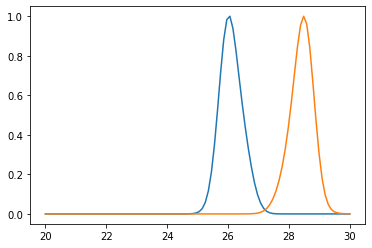

In [36]:
mix.select_down()
mix.make_kde()

In [47]:
def gaussian(x, mid, w, A):
    return A * np.exp(-0.5 * ((x - mid)**2) / w**2)

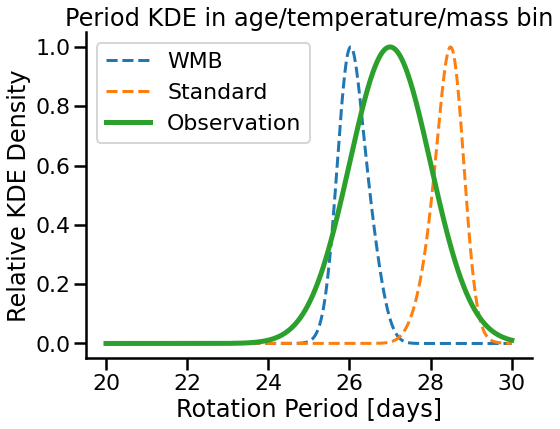

In [56]:
import seaborn as sns
sns.set_context('poster')
age=np.log(5.5)
npts=1000

prot = np.linspace(20.0, 30.0, npts)
solar_d_ro = [mix.dens_rocrit.pdf([1.0, 5777.0, age, n]) for n in np.log(prot)]
solar_d_stan = [mix.dens_stan.pdf([1.0, 5777.0, age, n]) for n in np.log(prot)]
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(prot, solar_d_ro / np.max(solar_d_ro), label='WMB', ls='--')
ax.plot(prot, solar_d_stan / np.max(solar_d_stan), label='Standard', ls='--')
ax.plot(prot, gaussian(prot, 27, 1, 1), label='Observation', lw=5)
ax.set_ylabel('Relative KDE Density')
ax.set_xlabel('Rotation Period [days]')
ax.legend(loc='upper left')
ax.set_title('Period KDE in age/temperature/mass bin')
sns.despine()

In [29]:
dfile = '../data/atium.csv'
df = pd.read_csv(dfile)
df['logage'] = np.log(df.age)
df['uplogage'] = np.log(df.age + df.upage) - df.logage
df['lologage'] = df.logage - np.log(df.age - df.loage)

df['logP'] = np.log(df.P)
df['uplogP'] = np.log(df.P + df.u_P) - df.logP
df['lologP'] = df.logP - np.log(df.P - df.l_P)

In [30]:
stars = []
for idx, row in df.iterrows():
    mass = [row.modmass, max([row.upmodmass, row.lomodmass])]
    teff = [row.Teff, row.eTeff]
    logage = [row.logage, max([row.uplogage, row.lologage])]
    logprot = [row.logP, max([row.uplogP, row.lologP])]
    feh = [row.feh, row.efeh]
    stars.append({'ID': str(row.KIC), 
                  'mass': mass, 
                  'teff': teff, 
                  'logage':  logage, 
                  'logprot': logprot,
                  'feh': feh})

<ipython-input-28-2ddbf5e9db79>:67: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(prot, solar_d_ro / np.max(solar_d_ro))
<ipython-input-28-2ddbf5e9db79>:68: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(prot, solar_d_stan / np.max(solar_d_stan))


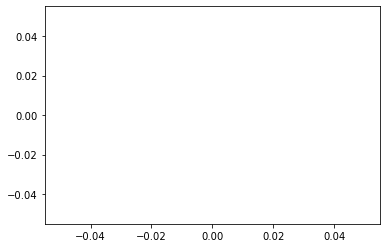

In [31]:
mix = mix()
inp = stars[2]

mix.select_down(mass=[inp['mass'][0], inp['mass'][1]*3],
                 teff=[inp['teff'][0], inp['teff'][1]*3],
                 age=[inp['logage'][0], inp['logage'][1]*3])
mix.set_obs(ID=inp['ID'],
             mass=inp['mass'],
             teff=inp['teff'],
             age=inp['logage'],
             prot=inp['logprot'])

mix.make_kde()
mix.plot_kde_example()

In [35]:
mix.dens_rocrit

KDE instance
Number of variables: k_vars = 4
Number of samples:   nobs = 5638
Variable types:      cccc
BW selection method: user-specified